The California Housing Prices dataset is used to build a model to predict the median housing price in any district, given all the other metrics. The data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

In [ ]:
from google.colab import files
uploaded = files.upload()

In [153]:
import pandas as pd
housing = pd.read_csv('housing (1).csv')

# look the top 5 rows
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [154]:
# total number of rows, attribute's type and number of non null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. The total_bedrooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. All attributes are numerical, except the ocean_proximity field which is a categorical attribute.

In [155]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [156]:
# summary of numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


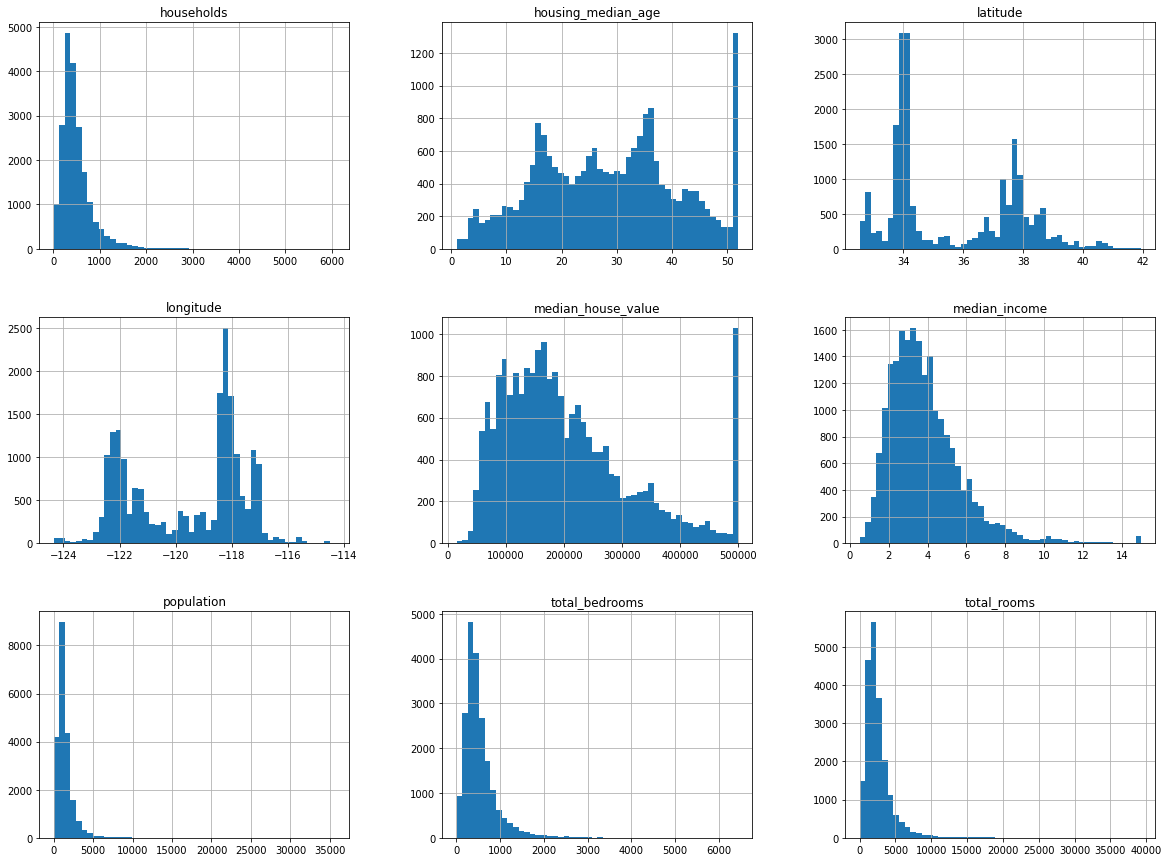

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

- the median income attribute does not look like it is expressed in USD. The number represent tens of thousands of dollars (3 means $30000)
- these attributes have very different scales
- many histograms are tail-heavy as they extend much further to the right of the median thatn to the left. These attributes will be transformed into more bell-shaped distributions

## **Creating a test set**

In [158]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [159]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [160]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2)

In [161]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6060,-117.81,34.01,12.0,9197.0,1642.0,4332.0,1554.0,4.9589,282100.0,<1H OCEAN
787,-122.09,37.63,34.0,1457.0,242.0,735.0,249.0,3.9167,189500.0,NEAR BAY
18138,-122.00,37.34,31.0,3344.0,620.0,1604.0,572.0,5.2108,351500.0,<1H OCEAN
8104,-118.22,33.79,28.0,3008.0,629.0,2537.0,596.0,2.3000,137500.0,NEAR OCEAN
446,-122.29,37.87,52.0,895.0,198.0,386.0,204.0,3.8750,182600.0,NEAR BAY


Most median income values are clustered around 1.5 to 6 ($15,000–$60,000) but some median incomes go far beyond 6.

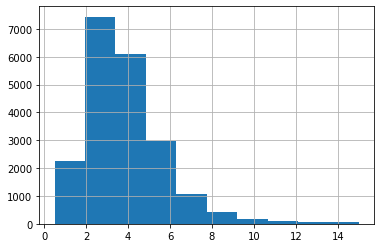

In [162]:
housing['median_income'].hist()

In [163]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [164]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

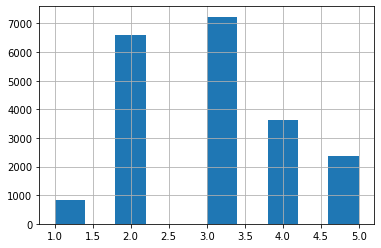

In [165]:
housing["income_cat"].hist()

In [166]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [167]:
# income category proportion in the test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [168]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [169]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [170]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.034884,-12.408759,-0.243309
2,0.318847,0.318798,0.320252,0.440663,-0.015195
3,0.350581,0.350533,0.353198,0.746269,-0.013820
4,0.176308,0.176357,0.179990,2.088486,0.027480
5,0.114438,0.114583,0.111676,-2.413209,0.127011


In [171]:
# remove income_cat attribute
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## **Visualizing the Data**

In [172]:
housing = strat_train_set.copy()

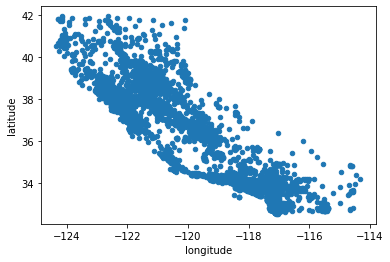

In [173]:
# scatterplot of all districts
housing.plot(kind="scatter", x="longitude", y="latitude")

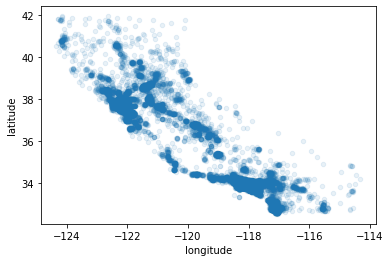

In [174]:
# visualize the places where there is a high density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Looking a t hte housing prices, the radius of each circle represents the district's population and the color represents the price. The colour map ranges from blue (low values) to red (high prices). Larger circles indicate areas with a larger population.

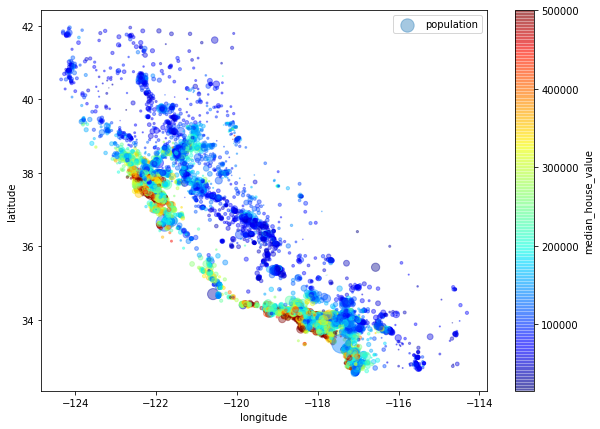

In [175]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

This image illustrates that the housing prices are very much related to the location (close to the ocean) and to the population density.

## **Correlations**

In [176]:
corr_matrix = housing.corr()

In [177]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686660
total_rooms           0.137029
housing_median_age    0.101931
households            0.069373
total_bedrooms        0.053135
population           -0.022429
longitude            -0.043872
latitude             -0.145271
Name: median_house_value, dtype: float64

There is a strong positive correlation between median house value and median income. There is also a small negative correlation between the latitude and hte median house value, so prices tend to go down when going north).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfb37bf5c0>,
      dtype=object)

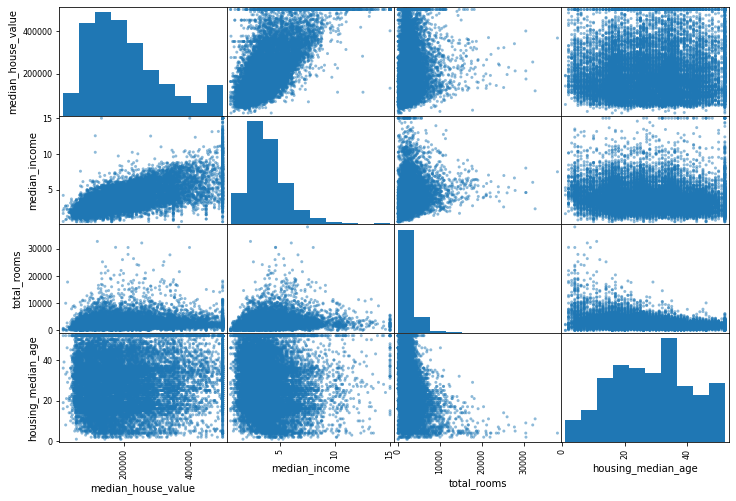

In [178]:
# scatter matrix using the most correlated attributes with the median housing value
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

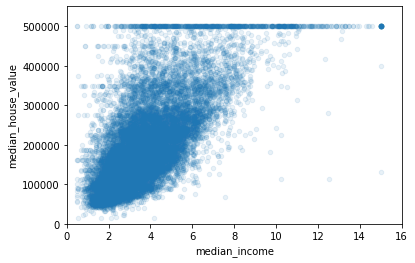

In [179]:
# median income v median house value
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

- The correlation is very stron (upward trend)
- Price cap visible as a horizontal line at 500000. There are other less obvious strain lines at 450000 and 350000.

The total number of rooms in a district is not very useful without knowing how many households there are. So, the number of rooms per household can be useful. Similarly, the total number of bedrooms by itself is not very useful. Comparing it to the number of rooms could be a good idea. And the population per household also seems like an interesting attribute combination.

In [180]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [181]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686660
rooms_per_household         0.147410
total_rooms                 0.137029
housing_median_age          0.101931
households                  0.069373
total_bedrooms              0.053135
population                 -0.022429
population_per_household   -0.033085
longitude                  -0.043872
latitude                   -0.145271
bedrooms_per_room          -0.259488
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district;so, the larger the houses, the more expensive they are.

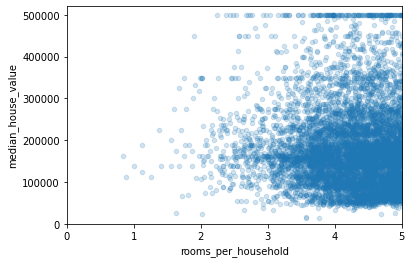

In [182]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [183]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16350.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16350.000000,16512.000000
mean,-119.570378,35.633780,28.755087,2631.043786,537.188073,1421.400557,498.854712,3.870345,206750.675569,5.438062,0.213015,3.025763
std,2.004660,2.136682,12.610232,2180.249194,420.730930,1138.445364,382.205959,1.896291,115181.256393,2.585360,0.058030,6.438362
min,-124.350000,32.540000,1.000000,2.000000,2.000000,5.000000,2.000000,0.499900,14999.000000,0.846154,0.100000,0.970588
25%,-121.800000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,2.565750,119400.000000,4.436813,0.175477,2.427791
50%,-118.490000,34.260000,29.000000,2124.000000,433.000000,1163.000000,409.000000,3.538500,180100.000000,5.231692,0.203125,2.816602
75%,-118.010000,37.720000,37.000000,3142.000000,645.000000,1714.000000,603.000000,4.746325,264625.000000,6.047832,0.240000,3.276461
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,599.714286


## **Data Cleaning**

In [184]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [185]:
# total bedroom has some missing values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
738,-122.14,37.67,37.0,3342.0,NaN,1635.0,557.0,4.7933,NEAR BAY
19818,-119.30,36.57,32.0,728.0,NaN,461.0,149.0,3.0156,INLAND
19959,-119.32,36.25,21.0,1231.0,NaN,609.0,206.0,2.8365,INLAND
8337,-118.31,33.94,40.0,1550.0,NaN,798.0,270.0,3.7750,<1H OCEAN
6835,-118.12,34.08,35.0,2248.0,NaN,1762.0,622.0,3.0000,<1H OCEAN


In [186]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [187]:
# remove the categorical attribute because median can only be calculated on numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)

In [188]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [189]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2124.    ,  433.    , 1163.    ,
        409.    ,    3.5385])

In [190]:
# transform the training set by replacing missing values with the learned medians
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
738,-122.14,37.67,37.0,3342.0,433.0,1635.0,557.0,4.7933
19818,-119.30,36.57,32.0,728.0,433.0,461.0,149.0,3.0156
19959,-119.32,36.25,21.0,1231.0,433.0,609.0,206.0,2.8365
8337,-118.31,33.94,40.0,1550.0,433.0,798.0,270.0,3.7750
6835,-118.12,34.08,35.0,2248.0,433.0,1762.0,622.0,3.0000


In [191]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
16842,-122.45,37.63,28.0,4946.0,848.0,2683.0,824.0,5.7480
11865,-121.19,40.23,10.0,1572.0,232.0,247.0,104.0,5.8453
15608,-116.87,32.75,15.0,2053.0,321.0,993.0,309.0,5.5164
17703,-121.82,37.31,22.0,2044.0,402.0,1925.0,429.0,3.7102
7823,-118.13,33.90,38.0,1475.0,269.0,827.0,265.0,4.7663


In [192]:
# preprocess the categorical input feature
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
16842,NEAR OCEAN
11865,INLAND
15608,<1H OCEAN
17703,<1H OCEAN
7823,<1H OCEAN
12957,INLAND
15191,<1H OCEAN
11609,<1H OCEAN
12468,INLAND
8093,NEAR OCEAN


In [193]:
# one-hot encoder to convert categorical values into one-hot vectors
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [194]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]])

In [195]:
# list of categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [196]:
# creating a custom transformer to add extra attributes
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [197]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
16842,-122.45,37.63,28,4946,848,2683,824,5.748,NEAR OCEAN,6.00243,3.25607
11865,-121.19,40.23,10,1572,232,247,104,5.8453,INLAND,15.1154,2.375
15608,-116.87,32.75,15,2053,321,993,309,5.5164,<1H OCEAN,6.64401,3.21359
17703,-121.82,37.31,22,2044,402,1925,429,3.7102,<1H OCEAN,4.76457,4.48718
7823,-118.13,33.9,38,1475,269,827,265,4.7663,<1H OCEAN,5.56604,3.12075


# **Feature Scaling**

Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. In this dataset, the total number of rooms ranges from about 6 to 39,320 while the median incomes only range from 0 to 15.

In [198]:
# creating a pipeline for the numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [199]:
housing_num_tr

array([[-1.43650786,  0.93428996, -0.05988074, ...,  0.21829942,
         0.03577184, -0.66821243],
       [-0.8079532 ,  2.15116661, -1.4873362 , ...,  3.74323785,
        -0.10107891, -1.04551146],
       [ 1.34709138, -1.3496939 , -1.09082079, ...,  0.46646807,
         0.02917435, -0.9068224 ],
       ...,
       [ 0.50901849, -0.6336088 , -1.01151771, ...,  0.75856538,
        -0.0210872 , -2.60750356],
       [-1.36167993,  1.2572303 , -0.69430539, ..., -0.36873324,
        -0.11711777,  0.34545765],
       [ 0.853227  , -0.76933735, -1.4873362 , ...,  0.48200142,
         0.03608196, -0.88400213]])

In [200]:
# creating a single transformer able to apply the appropriate transformations to each column
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [201]:
housing_prepared

array([[-1.43650786,  0.93428996, -0.05988074, ...,  0.        ,
         0.        ,  1.        ],
       [-0.8079532 ,  2.15116661, -1.4873362 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.34709138, -1.3496939 , -1.09082079, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.50901849, -0.6336088 , -1.01151771, ...,  0.        ,
         0.        ,  0.        ],
       [-1.36167993,  1.2572303 , -0.69430539, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.853227  , -0.76933735, -1.4873362 , ...,  0.        ,
         0.        ,  0.        ]])

In [202]:
housing_prepared.shape

(16512, 16)

## **Training and Evaluating on the Training Set**

In [203]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [204]:
# full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [309149.43216345 175868.78999477 255832.12466692 188104.84193139
 257350.56089722]


In [205]:
# Compare against the actual values
print("Labels:", list(some_labels))

Labels: [302100.0, 193800.0, 248900.0, 177500.0, 191600.0]


The prediction are not exactly accurate

In [206]:
some_data_prepared

array([[-1.43650786,  0.93428996, -0.05988074,  1.0618173 ,  0.74463393,
         1.10821098,  0.85073277,  0.99020268,  0.21829942,  0.03577184,
        -0.66821243,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.8079532 ,  2.15116661, -1.4873362 , -0.48575909, -0.72632281,
        -1.03161395, -1.03312536,  1.04151493,  3.74323785, -0.10107891,
        -1.04551146,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.34709138, -1.3496939 , -1.09082079, -0.26513542, -0.51379821,
        -0.37631453, -0.49674909,  0.86806581,  0.46646807,  0.02917435,
        -0.9068224 ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.12223053,  0.78452053, -0.53569923, -0.26926352, -0.32037695,
         0.44237054, -0.18277273, -0.0844541 , -0.26051053,  0.22699267,
        -0.26953384,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.71853671, -0.81146   ,  0

In [207]:
# computing mean square error
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68198.72155628655

This is not a great score as most median_housing_values range between $120000-$265000, so a prediction error of $ 68302 is not very good.

In [208]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49189.9230347305

In [209]:
# selecting a more powerful model that can find nonlinear relationships in the data
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [210]:
# evaluating the model on the training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The model has badly overfit the data

## **Better Evaluation using Cross-Validation**

In [211]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [212]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [73804.62309938 66253.81790846 68399.78646818 70422.43437656
 65931.92659796 71276.80152175 69855.25090602 72843.67060512
 69917.37451821 72139.00798939]
Mean: 70084.46939910337
Standard deviation: 2490.900657139604


The decision tree seems to perform worse than the Linear Regression model.

In [213]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68773.99030893 67492.41384594 66140.0758702  71932.92153332
 66482.38894517 70110.05724882 64065.96502289 70850.41770704
 66408.11295765 72334.61530945]
Mean: 68459.09587494245
Standard deviation: 2633.556444872987


In [214]:
# training a new model: random forests
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [215]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18506.676563308218

In [216]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [50782.42180577 48416.7277754  49309.94266413 51796.85602903
 48143.71151422 53025.71747973 45650.5986693  50950.94145988
 49643.01339443 51692.17517247]
Mean: 49941.21059643554
Standard deviation: 2054.3245763892533


In [217]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     68459.095875
std       2776.012237
min      64065.965023
25%      66426.681955
50%      68133.202077
75%      70665.327592
max      72334.615309
dtype: float64

Random Forests performs better than the previous two models. However, the score on the training set is still much lower htan on the validation sets, so the model is still overfitting the training set.

## **Grid Search**

Grid search is used to fine-tune the hyerparameter values. The grid search will explore 12+6 =19 combinations of Random Forests regressor hyperparameter values, training each model 5 times.

In [219]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [220]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [221]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [222]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64309.45093890027 {'max_features': 2, 'n_estimators': 3}
55106.70412214386 {'max_features': 2, 'n_estimators': 10}
52758.06446525024 {'max_features': 2, 'n_estimators': 30}
59706.75587250354 {'max_features': 4, 'n_estimators': 3}
52298.95534331519 {'max_features': 4, 'n_estimators': 10}
50134.94446851611 {'max_features': 4, 'n_estimators': 30}
58523.51024002104 {'max_features': 6, 'n_estimators': 3}
51936.8667425467 {'max_features': 6, 'n_estimators': 10}
49910.26559114672 {'max_features': 6, 'n_estimators': 30}
58254.38819808964 {'max_features': 8, 'n_estimators': 3}
51665.04279016968 {'max_features': 8, 'n_estimators': 10}
49668.549412132976 {'max_features': 8, 'n_estimators': 30}
62067.85968831798 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54217.517058472054 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59505.94262731838 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52658.7858812496 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

The best solution by setting the max_features hyperparameter to 8 and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49668, which is slightly better than the previous score got using the default hyperparameter values.

In [223]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.077419,0.001657,0.004822,0.000564,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.916477e+09,-4.207681e+09,-4.198680e+09,-4.208492e+09,-4.147197e+09,-4.135705e+09,1.119261e+08,18,-1.024959e+09,-1.097133e+09,-1.126368e+09,-1.101358e+09,-1.089998e+09,-1.087963e+09,3.379982e+07
1,0.244994,0.005564,0.011892,0.000283,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.990669e+09,-2.941319e+09,-3.167595e+09,-2.936654e+09,-3.147507e+09,-3.036749e+09,1.006353e+08,11,-5.739230e+08,-5.842251e+08,-5.843938e+08,-5.708430e+08,-5.606797e+08,-5.748129e+08,8.907092e+06
2,0.727351,0.009762,0.033722,0.001224,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.709130e+09,-2.708453e+09,-2.903790e+09,-2.741860e+09,-2.853833e+09,-2.783413e+09,8.039075e+07,9,-4.302296e+08,-4.301498e+08,-4.349905e+08,-4.375901e+08,-4.300049e+08,-4.325930e+08,3.129639e+06
3,0.123004,0.002251,0.004483,0.000102,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.544321e+09,-3.508426e+09,-3.606498e+09,-3.462543e+09,-3.702695e+09,-3.564897e+09,8.343594e+07,16,-9.382043e+08,-9.337987e+08,-9.825301e+08,-9.195135e+08,-9.638185e+08,-9.475730e+08,2.258654e+07
4,0.400395,0.007654,0.012020,0.000321,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.672956e+09,-2.722730e+09,-2.778029e+09,-2.686271e+09,-2.815918e+09,-2.735181e+09,5.435732e+07,7,-5.039580e+08,-4.885831e+08,-5.173797e+08,-5.202781e+08,-4.993759e+08,-5.059150e+08,1.170232e+07
5,1.181659,0.008413,0.032795,0.000101,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.493484e+09,-2.493169e+09,-2.596628e+09,-2.440574e+09,-2.543708e+09,-2.513513e+09,5.282974e+07,3,-3.829984e+08,-3.829875e+08,-3.907545e+08,-3.919170e+08,-3.743501e+08,-3.846015e+08,6.350464e+06
6,0.165002,0.001793,0.004396,0.000096,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.346829e+09,-3.697982e+09,-3.373461e+09,-3.237253e+09,-3.469482e+09,-3.425001e+09,1.552507e+08,14,-8.568540e+08,-8.995398e+08,-9.236335e+08,-9.154115e+08,-8.768042e+08,-8.944486e+08,2.466495e+07
7,0.549120,0.010125,0.012264,0.000789,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.604449e+09,-2.788331e+09,-2.730437e+09,-2.643242e+09,-2.720731e+09,-2.697438e+09,6.553975e+07,6,-4.863487e+08,-5.008558e+08,-4.902123e+08,-5.189582e+08,-4.880423e+08,-4.968834e+08,1.213859e+07
8,1.649248,0.009120,0.032920,0.000265,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.413742e+09,-2.542592e+09,-2.557778e+09,-2.415491e+09,-2.525570e+09,-2.491035e+09,6.322417e+07,2,-3.802063e+08,-3.820351e+08,-3.757155e+08,-3.950216e+08,-3.736627e+08,-3.813282e+08,7.477045e+06
9,0.208637,0.003007,0.004549,0.000187,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.293191e+09,-3.419249e+09,-3.511098e+09,-3.199167e+09,-3.545163e+09,-3.393574e+09,1.306303e+08,13,-8.559923e+08,-9.031547e+08,-9.069940e+08,-9.043370e+08,-8.867748e+08,-8.914506e+08,1.909869e+07


## **Evaluation on Test set**

In [224]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [225]:
final_rmse

49433.36748469839